# Figure - BO showcase

In [1]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
def get_error_params_from_str(string):
    import re
    # Regular expressions to extract values for error, dz, tilt_y, and tilt_x
    match_error  = re.search(r'_error_([\d.eE+-]+)', string)
    match_dz     = re.search(r'_dz_([-.\d]+)', string)
    match_tilt_y = re.search(r'_tilt_y_([-.\d]+)', string)
    match_tilt_x = re.search(r'_tilt_x_([-.\d]+)', string)

    if match_error and match_dz and match_tilt_y and match_tilt_x:
        return [
            f"{float(match_error.group(1)):.5f}",
            f"{float(match_dz.group(1)):.1f}",
            f"{float(match_tilt_y.group(1)):.1f}",
            f"{float(match_tilt_x.group(1)):.1f}"
        ]
    else:
        print("One or more parameters not found")
        return None  # Return None if any of the parameters are missing

In [3]:
from scipy.interpolate import interp1d

def get_error_vs_time_from_studies(study, elasped_time=14400, timepoints=200):
    """ Calculate optimization history of a study / studies """
    from optuna.study import Study
    
    if isinstance(study, Study):
        studies = [study]
    else:
        studies = list(study)
    
    optimization_histories = []
    for study in studies:
    
        trials = study.get_trials()
            
        # 1. Get the start and end time of the study (convert to seconds)
        first_start_time = trials[0].datetime_start.timestamp()

        # 2. Filter only completed trials
        completed_trials = [t for t in trials if t.state == 1] # 1 is complete, 2 is pruned

        # 3. Collect start times and errors for completed trials
        start_times = np.array([t.datetime_start.timestamp() - first_start_time for t in completed_trials])
        errors = np.array([t.values for t in completed_trials])

        # 4. Compute best-so-far (cumulative minimum)
        best_so_far = np.minimum.accumulate(errors).squeeze()

        # 5. Create a common time grid from 0 to last_end_time - first_start_time
        common_time_grid = np.linspace(0, elasped_time, timepoints)

        # 6. Interpolate
        interp_func = interp1d(start_times, best_so_far, kind='previous', fill_value="extrapolate")
        interpolated_errors = interp_func(common_time_grid)
        optimization_histories.append(interpolated_errors)
    return np.array(optimization_histories), common_time_grid

## Sampler + Pruner panel (Average after interpolate in time)

In [4]:
path_random       = "sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_random_contrast_seed.sqlite3"
path_random_prune = "sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_random_prune_contrast_seed.sqlite3"
path_TPE          = "sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_TPE_contrast_seed.sqlite3"
path_TPE_prune    = "sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_TPE_prune_contrast_seed.sqlite3"

labels = ['Random',
          'Random + Pruner',
          'TPE', 
          'TPE + Pruner']

paths = [path_random, 
         path_random_prune,
         path_TPE, 
         path_TPE_prune]

round_idx = 20
studies_all = []
histories_all = []
figs = []
arrs = []
for i, path in enumerate(paths):
    studies = [optuna.load_study(study_name=f'study_{str(idx).zfill(2)}', storage=path) for idx in range(round_idx)]
    print(f"\nFound {len(studies)} studies in database: {path}")
    print(f"Each study contains in average {np.mean([len(study.get_trials()) for study in studies]):.2f} trials")
    
    num_completed = 0
    num_pruned = 0
    for study in studies:
        for trial in study.get_trials():
            if trial.state == 1:
                num_completed += 1
            elif trial.state == 2:
                num_pruned += 1
    print(f"Each study contains in average {num_completed/len(studies):.2f} completed and {num_pruned/len(studies):.2f} pruned trials")
    
    histories, time_grid = get_error_vs_time_from_studies(studies, elasped_time=14400, timepoints=200)
    studies_all.append(studies)
    histories_all.append(histories)


Found 20 studies in database: sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_random_contrast_seed.sqlite3
Each study contains in average 124.85 trials
Each study contains in average 124.85 completed and 0.00 pruned trials

Found 20 studies in database: sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_random_prune_contrast_seed.sqlite3
Each study contains in average 188.10 trials
Each study contains in average 56.70 completed and 131.40 pruned trials

Found 20 studies in database: sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_TPE_contrast_seed.sqlite3
Each study contains in average 125.65 trials
Each study contains in average 125.65 completed and 0.00 pruned trials

Found 20 studies in database: sqlite:///03_output/hypertune/hypertune_optuna_ZSM5_TPE_prune_contrast_seed.sqlite3
Each study contains in average 155.55 trials
Each study contains in average 79.80 completed and 75.75 pruned trials


## Importance panel

In [5]:
from optuna.visualization import plot_param_importances
# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.PedAnovaImportanceEvaluator.html
# The importance can be interpreted as how important each hyperparameter is to get the performance better than baseline.
# If evaluate on local, the importances imply how importance each parameter is during optimization. Meanwhile, evaluate_on_local=False gives the importances in the specified search_space.

path_importance   = "sqlite:///03_output/hypertune/hypertune_importance_ZSM5.sqlite3"
study_names = optuna.study.get_all_study_names(storage=path_importance)
study_name = 'contrast'
study = optuna.load_study(study_name=study_name, storage=path_importance)
evaluator = optuna.importance.PedAnovaImportanceEvaluator(baseline_quantile=0.10, evaluate_on_local=True)
importance = optuna.importance.get_param_importances(study, evaluator=evaluator)
importance

C:\Users\chiahao3\AppData\Local\Temp\ipykernel_20168\77148123.py:10: ExperimentalWarning: PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.
  evaluator = optuna.importance.PedAnovaImportanceEvaluator(baseline_quantile=0.10, evaluate_on_local=True)


{'batch_size': 0.6617312612795615,
 'oplr': 0.2368902546663561,
 'optimizer': 0.07710723503307133,
 'plr': 0.024271249021011104}

## Final figure

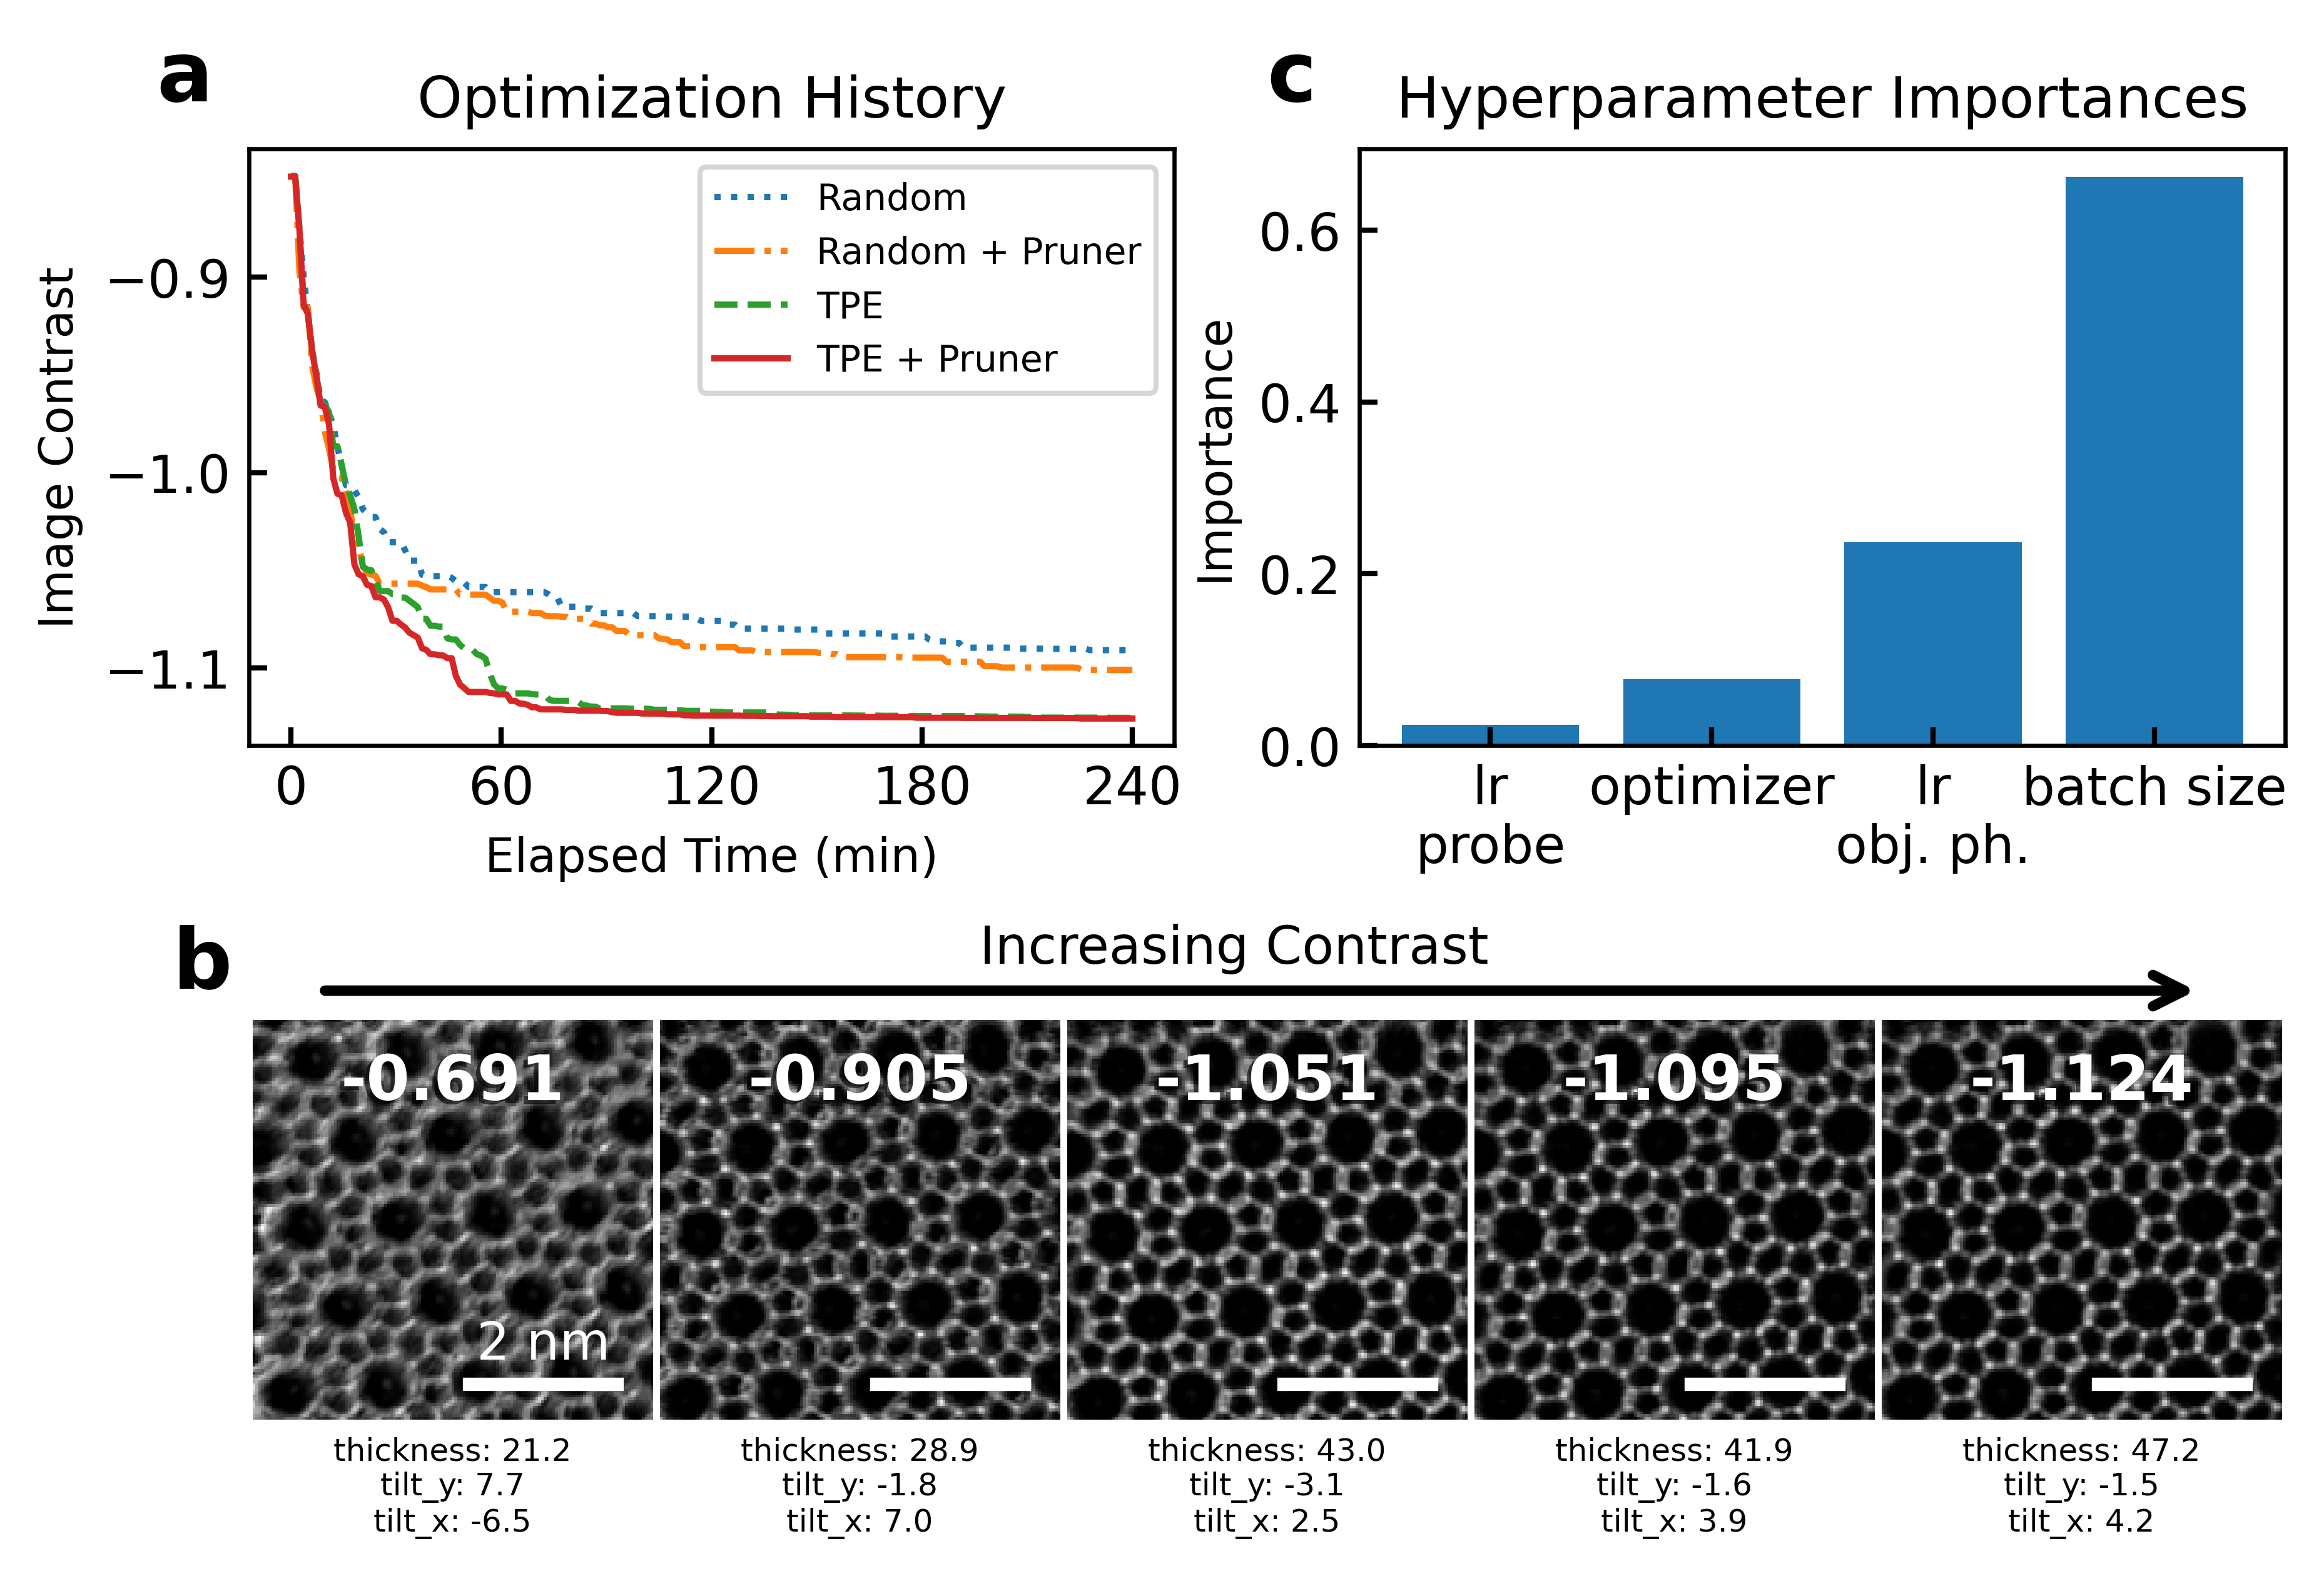

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from tifffile import imread
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

mpl.rc('xtick', direction='in')
mpl.rc('xtick.major', width=1, size=3.5)
mpl.rc('xtick.minor', width=1, size=2)
mpl.rc('ytick', direction='in')
mpl.rc('ytick.major', width=1, size=3.5)
mpl.rc('ytick.minor', width=1, size=2)

# Global font/line control
linewidth = 1.2
markersize = 4
fontsize_title = 11
fontsize_subtitle = 7
fontsize_label = 9
fontsize_legend = 7

# Scale bar settings
scale_bar_length = 20/0.3591  # Length of the scale bar in pixels (1 px = 0.3591 Ang)
scale_bar_label = "2 nm"  # Label for the scale bar
scale_bar_color = "white"
fontprops = fm.FontProperties(size=10)

shadow_offset = [-0.01, -0.01]
text_offset = [0.5,0.92]

# Create figure with constrained layout
fig = plt.figure(figsize=(7, 4.4), dpi=600, constrained_layout=False)
gs0 = fig.add_gridspec(2, 1, height_ratios=[1, 0.67], hspace=0.55)  # Two main rows

gs00 = gs0[0].subgridspec(1, 2, width_ratios=[1, 1], wspace=0.20)  # Top row with 2 subplots
gs01 = gs0[1].subgridspec(1, 5, wspace=0)  # Bottom row with 5 image panels

# Panel a: Optimization History
linestyles = [':', '-.', '--', '-']  # Define different linestyles
ax1 = fig.add_subplot(gs00[0])
for i, label in enumerate(labels):
    line = histories_all[i].mean(0)
    ax1.plot(time_grid/60, line, label=label, linewidth=linewidth, linestyle=linestyles[i])
ax1.set_title('Optimization History', fontsize=fontsize_title)
ax1.set_xlabel('Elapsed Time (min)', fontsize=fontsize_label)
ax1.set_ylabel('Image Contrast', fontsize=fontsize_label)
ax1.set_xticks([0, 60, 120, 180, 240])
ax1.text(-0.1, 1.08, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax1.legend(fontsize=fontsize_legend)

# Panel b: Hyperparameter Importances
hyperparam_labels = ['lr\nprobe', 'optimizer', 'lr\nobj. ph.', 'batch size']
hyperparam_keys = ['plr', 'optimizer', 'oplr', 'batch_size']
importances = [importance[key] for key in hyperparam_keys]
ax2 = fig.add_subplot(gs00[1])
ax2.set_title('Hyperparameter Importances', fontsize=fontsize_title)
ax2.bar(hyperparam_labels, importances, color='C0')
ax2.set_ylabel('Importance', fontsize=fontsize_label)
ax2.text(-0.1, 1.08, 'c', transform=ax2.transAxes, fontsize=16, fontweight='bold')

# Bottom row: Image panels (5 individual subplots)
output_dir = '03_output/ZSM5/20250205_ptyrad_ZSM5_optuna_seed/hypertune_TPESampler_contrast_03'

# Get files from folder
all_files = os.listdir(output_dir)
file_names = []
for file in all_files:
    if file.startswith('objp_zsum_crop_08bit_error_'):
        file_names.append(file)
file_names.sort()
# Get images and errors
errors = []
imgs = []
params = []
for file_name in file_names:
    imgs.append(imread(os.path.join(output_dir, file_name)))
    error_params = get_error_params_from_str(file_name)
    errors.append(error_params[0])
    params.append(error_params[1:])
# Sort images with error ()
idx_sort = np.argsort(errors)
imgs_sort = np.array(imgs)[idx_sort]
selected_indices = np.linspace(0, len(imgs_sort)-1, gs01.ncols, endpoint=True, dtype=int)
error_values = np.array(errors)[idx_sort][selected_indices]
params_values = np.array(params)[idx_sort][selected_indices]

for i in range(gs01.ncols):
    ax = fig.add_subplot(gs01[i])
    
    if i ==0:
        ax.text(-0.20, 1.08, 'b', transform=ax.transAxes, fontsize=16, fontweight='bold')
    ax.imshow(imgs_sort[selected_indices[i]], cmap="gray")  # Replace with actual images
    ax.axis("off")  # Hide axes
    
    # Add scale bar
    if i == 0:
        scalebar = AnchoredSizeBar(ax.transData, scale_bar_length, scale_bar_label,
                                loc='lower right', pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                fontproperties=fontprops)
    else:
        scalebar = AnchoredSizeBar(ax.transData, scale_bar_length, '',
                                loc='lower right', pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    # Add label with text shadow
    error = f"{np.float32(error_values[i]):.3f}"
    ax.text(
        text_offset[0] + shadow_offset[0], text_offset[1] + shadow_offset[1], error,
        color='black', fontsize=12, fontweight='bold', transform=ax.transAxes,
        va='top', ha='center', alpha=0.6
    )
    ax.text(
        text_offset[0], text_offset[1], error, color='white', fontsize=12, fontweight='bold',
        va='top', ha='center', transform=ax.transAxes,
    )
    
    # Add params text below
    dz, tilt_y, tilt_x = params_values[i]
    fig.text(gs01[i].get_position(fig).x0 + gs01[i].get_position(fig).width / 2, 
             gs01[i].get_position(fig).y0 - 0.01,  # Adjust vertical spacing
             f"thickness: {dz}\ntilt_y: {tilt_y}\ntilt_x: {tilt_x}", 
             ha='center', va='top', fontsize=6)

# Add arrows and text labels using fig.text and FancyArrowPatch
fig.text(0.5, 0.38, "Increasing Contrast", ha='center', va='bottom', fontsize=10)

# Top arrow (from left to right)
arrow_top = patches.FancyArrowPatch((0.15, 0.37), (0.87, 0.37), transform=fig.transFigure, 
                                   arrowstyle="->", lw=2, color="black", mutation_scale=15)
fig.patches.append(arrow_top)

plt.savefig("05_figures/Fig_06_BO_showcase.png", bbox_inches="tight")
plt.savefig("05_figures/Fig_06_BO_showcase.pdf", bbox_inches="tight")
plt.show()
